## Overview
This notebook performs denoising on our BSDS300 images through non-learning methods. These methods include Bilateral Filtering, Non-Local Means, BM3D, and Anisotropic Diffusion.

User passes in either a Gaussian parameter, a Poisson parameter, or both. Result will show original clean image, noisy image, and results of the previously mentioned methods. Entire script is encapsulated in the denoise() function

In [9]:
import os
import logging
import warnings; warnings.filterwarnings("ignore");
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.transform import resize
from torch.utils.data import DataLoader
from matplotlib import image

from bm3d import bm3d_rgb
from experiment_funcs import get_experiment_noise
from BSDS300Dataset import BSDS300Dataset


In [2]:
# important image-related data
dynamicRange = [0.0, 1.0]

In [3]:
def applyGaussianNoise(img, sigma):
    noisyImg = img + np.random.normal(scale=sigma, size=img.shape).astype(img.dtype)
    noisyImgClipped = np.clip(noisyImg, dynamicRange[0], dynamicRange[1])
    return noisyImgClipped

def applyPoissonNoise(img, peak):
    noisyImg = (np.random.poisson(img * peak) / peak).astype(img.dtype)
    noisyImgClipped = np.clip(noisyImg, dynamicRange[0], dynamicRange[1])
    return noisyImgClipped
    
def bilateralFilter(src, noisyImg):
    """
    Denoises image using Bilateral Filtering
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    
    :return denoisedImg (np.ndarray): denoised image
    :return bilateralPsnr (float): PSNR between source and denoised image
    """
    
    denoisedImg = cv2.bilateralFilter(noisyImg,d=7,sigmaColor=75,sigmaSpace=75)
    bilateralPsnr = round(psnr(src, denoisedImg), 2)

    return denoisedImg.clip(dynamicRange[0], dynamicRange[1]), bilateralPsnr

def nlm(src, noisyImg, h_factor = 1.5):
    """
    Denoises image using Non-Local Means (NLM)
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    :param h_factor (float): factor for controlling decay in patch weights as they deviate from the window of interest
    
    :return denoisedImg (np.ndarray): denoised image
    :return nlmPsnr (float): PSNR between source and denoised image
    """
    
    print(h_factor)
    sigmaEstimated = np.mean(estimate_sigma(noisyImg))
    denoisedImg = denoise_nl_means(noisyImg, 
                                   h = h_factor*sigmaEstimated, 
                                   fast_mode=True,
                                   patch_size=5,
                                   patch_distance=6,
                                   multichannel=True)

    nlmPsnr = round(psnr(src, denoisedImg), 2)
    return denoisedImg.clip(dynamicRange[0], dynamicRange[1]), nlmPsnr

def bm3d(src, noisyImg, noise_factor = 1):
    """
    Denoises image using Block-Matching and 3-D Filtering (bm3d)
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    
    :return denoisedImg (np.ndarray): denoised image
    :return bm3dPsnr (float): PSNR between source and denoised image
    """
    
    noiseType = 'gw'    # white noise
    sigmaEstimated = np.mean(estimate_sigma(noisyImg))
    randomSeed = 0
    sz = noisyImg.shape
    noise, psd, kernel = get_experiment_noise(noise_type=noiseType,
                                              noise_var=noise_factor * sigmaEstimated,
                                              realization=randomSeed,
                                              sz=sz)
    denoisedImg = bm3d_rgb(noisyImg, psd)
    bm3dPsnr = round(psnr(src, denoisedImg), 2)
    return denoisedImg.clip(dynamicRange[0], dynamicRange[1]), bm3dPsnr

    

In [6]:
def denoiseWithAllMethods(path = None, img = None, sigma = None, peak = None):
    """
    Adds noise to source image, then denoises the result using a variety of 
    non-learning-based denoising methods.
    
    :param path (str): path to image (if not provided, function defaults to 'img' parameter)
    :param img (np.ndarray): image (if not provided, function defaults to 'path' parameter)
    :param sigma (float): variance of Gaussian noise
    :param peak (int): parameter used for applying Poisson noise
    
    :return gaussianImg (np.ndarray): source image perturbed with Gaussian noise
    :return gaussianDict (dict): maps to the results of each method (methods applied on Gaussian-perturbed images)
                                    along with the PSNR of those results
    :return poissonImg (np.ndarray): source image perturbed with Poisson noise
    :return poissonDict (dict): maps to the results of each method (methods applied on Poisson-perturbed images)
                                    along with the PSNR of those results
    """
    
    
    # Argument handling
    #--------------------------#
    if path is None and img is None:
        raise TypeError("Either image or image path must be provided.")
    
    if sigma is None and peak is None:
        raise TypeError("Received neither Gaussian parameter nor Poisson parameter.")
        
    if img is None:
        img = io.imread(path).astype(np.float32) / 255
        print(f"img dtype: {img.dtype}")
    #--------------------------#
    
    # Gaussian denoising
    #--------------------------#
    gaussianImg = applyGaussianNoise(img, sigma) if sigma != None else None
    gaussianDict = {}
    if sigma != None:
        bilateralResult, bilateralPsnr = bilateralFilter(img, gaussianImg)
        nlmResult, nlmPsnr = nlm(img, gaussianImg)
        bm3dResult, bm3dPsnr = bm3d(img, gaussianImg)
        gaussianDict["BF"] = (bilateralResult, bilateralPsnr)
        gaussianDict["NLM"] = (nlmResult, nlmPsnr)
        gaussianDict["BM3D"] = (bm3dResult, bm3dPsnr)

    #--------------------------#
    
    # Poisson denoising
    #--------------------------#
    poissonImg = applyPoissonNoise(img, peak) if peak != None else None
    poissonDict = {}
    if peak != None:
        bilateralResult, bilateralPsnr = bilateralFilter(img, poissonImg)
        nlmResult, nlmPsnr = nlm(img, poissonImg)
        bm3dResult, bm3dPsnr = bm3d(img, poissonImg)
        poissonDict["BF"] = (bilateralResult, bilateralPsnr)
        poissonDict["NLM"] = (nlmResult, nlmPsnr)
        poissonDict["BM3D"] = (bm3dResult, bm3dPsnr)
        
    #--------------------------#
    
    return gaussianImg, gaussianDict, poissonImg, poissonDict
    

In [7]:
def plotResults(img, gaussianImg, gaussianResults, poissonImg, poissonResults, fname=None):
    """
    Plot the results of denoiseWithAllMethods.
    
    :param img (np.ndarray): Original image.
    :param gaussianImg (np.ndarray): Image perturbed by Gaussian noise
    :param gaussianResults (dict): maps to the results of each method (methods applied on Gaussian-perturbed images)
                                    along with the PSNR of those results
    :param poissonImg (np.ndarray): Image perturbed by Poisson Noise
    :param poissonResults (dict): maps to the results of each method (methods applied on Poisson-perturbed images)
                                    along with the PSNR of those results
    :param fname (str): Output file name for figure. Does not save figure to disk if fname is None
    """
    
    fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(12,12))
    ax[0,0].imshow(img)
    ax[0,0].set_title("Original Image")

    ax[0,1].imshow(gaussianImg)
    ax[0,1].set_title("Image w/Gaussian Noise")

    ax[0,2].imshow(poissonImg)
    ax[0,2].set_title("Image w/Poisson Noise")

    result, psnr_ = gaussianResults["BF"]
    ax[1,0].imshow(result)
    ax[1,0].set_title(f"Bilateral Filter on Gaussian Noise ({psnr_})")

    result, psnr_ = gaussianResults["NLM"]
    ax[1,1].imshow(result)
    ax[1,1].set_title(f"NLM on Gaussian Noise ({psnr_})")

    result, psnr_ = gaussianResults["BM3D"]
    ax[1,2].imshow(result)
    ax[1,2].set_title(f"BM3D on Gaussian Noise ({psnr_})")

    result, psnr_ = poissonResults["BF"]
    ax[2,0].imshow(result)
    ax[2,0].set_title(f"Bilateral Filter on Poisson Noise ({psnr_})")

    result, psnr_ = poissonResults["NLM"]
    ax[2,1].imshow(result)
    ax[2,1].set_title(f"NLM on Poisson Noise ({psnr_})")

    result, psnr_ = poissonResults["BM3D"]
    ax[2,2].imshow(result)
    ax[2,2].set_title(f"BM3D on Poisson Noise ({psnr_})")

    plt.tight_layout()
    
    if fname is not None:
        plt.savefig(fname)

In [5]:
root = "BSR/BSDS500/data/images/test"
files = ["112056.jpg", "106005.jpg", "103029.jpg", "100099.jpg", "100007.jpg"]
files = ["112056.jpg"]
noiseParams = [(0.1, 5), (0.15, 7), (0.3, 15)]

for file in files:
    print(f"Processing {file}")
    img_name = os.path.splitext(file)[0]
    img_path = os.path.join(root, file)
    img = io.imread(img_path).astype(np.float32) / 255.0

    for param in noiseParams:
        print(f"\tNoise Parameters: {param}")
        sigma = param[0]
        peak = param[1]
        gaussianImg, gaussianResults, poissonImg, poissonResults = denoiseWithAllMethods(img=img, 
                                                                                         sigma=sigma, 
                                                                                         peak=peak)
    
        image.imsave(f'nonlearning_results/{img_name}/Clean.png', img)
        gaussianPSNR = round(psnr(img, gaussianImg),2)
        image.imsave(f'nonlearning_results/{img_name}/Noisy_G_{sigma}_PSNR_{gaussianPSNR}.png', gaussianImg)
        poissonPSNR = round(psnr(img, poissonImg),2)
        image.imsave(f'nonlearning_results/{img_name}/Noisy_P_{peak}_PSNR_{poissonPSNR}.png', poissonImg)

        for key in gaussianResults:
            value, psnr_ = gaussianResults[key]
            image.imsave(f'nonlearning_results/{img_name}/G_{sigma}_{key}_PSNR_{psnr_}.png', value)

        for key in poissonResults:
            value, psnr_ = poissonResults[key]
            image.imsave(f'nonlearning_results/{img_name}/P_{peak}_{key}_PSNR_{psnr_}.png', value)

Processing 112056.jpg
	Noise Parameters: (0.1, 5)


NameError: name 'denoiseWithAllMethods' is not defined

In [11]:
root = '/Users/baba/Desktop'
noise_models = ['gaussian', 'poisson']
gauss_params = ['0.1', '0.15', '0.3']
poisson_params = ['5','7', '15']
image_indices = ['0', '2', '8', '13', '22']

for model in noise_models:
    print(f"Processing {model} noise models")
    noise_params = gauss_params if model == 'gaussian' else poisson_params
    
    for param in noise_params:
        print(f"\tNoise param = {param}")
        img_path = os.path.join(root, model, param)
        
        results_dir = "nonlearning_results"
        if results_dir not in os.listdir(img_path):
            os.mkdir(os.path.join(img_path, results_dir))
        output_path = os.path.join(img_path, results_dir)
        
        nlmElapsed = []
        bfElapsed = []
        bm3dElapsed = []
        for idx in image_indices:
            print(f"\t\tProcessing image {idx}")
            img_fname = os.path.join(img_path, f"Image_{idx}_Clean.jpeg")
            noisy_fname = os.path.join(img_path, f"Image_{idx}_Noisy.jpeg")
            denoised_fname = os.path.join(img_path, f"Image_{idx}_Denoised.jpeg")
            
            clean_img = io.imread(img_fname).astype(np.float32) / 255.0
            noisy_img = io.imread(noisy_fname).astype(np.float32) / 255.0
            denoised_img = io.imread(denoised_fname).astype(np.float32) / 255.0
            
            # Denoise with NLM and report timing
            h_factor = 10 if model == 'poisson' else 30
            nlmStart = time.time()
            nlmResult, nlmPSNR = nlm(clean_img, noisy_img, h_factor = h_factor)
            nlmElapsed.append(time.time() - nlmStart)
            
            # Denoise with Bilateral Filtering and report timing
            bfStart = time.time()
            bfResult, bfPSNR = bilateralFilter(clean_img, noisy_img)
            bfElapsed.append(time.time() - bfStart)
            
            # Denoising with BM3D and report timing
            bm3dStart = time.time()
            bm3dResult, bm3dPSNR = bm3d(clean_img, noisy_img, noise_factor = 10)
            bm3dElapsed.append(time.time() - bm3dStart)

            noisyPSNR = round(psnr(clean_img, noisy_img), 2)
            denoisedPSNR = round(psnr(clean_img, denoised_img), 2)
            nlmPSNR = round(nlmPSNR, 2)
            bfPSNR = round(bfPSNR, 2)
            bm3dPSNR = round(bm3dPSNR, 2)
            
            n = "G" if model == 'gaussian' else "P"
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_Clean.png", clean_img)   # save clean image
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_Noisy_{noisyPSNR}.png", noisy_img)    # noisy image
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_MAML_{denoisedPSNR}.png", denoised_img)    # MAML
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_NLM_{nlmPSNR}.png", nlmResult)    # nlm
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_BF_{bfPSNR}.png", bfResult)    # bf
            image.imsave(f"{output_path}/Image_{idx}_{n}_{param}_BM3D_{bm3dPSNR}.png", bm3dResult)    # bm3d
            


Processing gaussian noise models
	Noise param = 0.1
		Processing image 0
30
		Processing image 2
30
		Processing image 8
30
		Processing image 13
30
		Processing image 22
30
	Noise param = 0.15
		Processing image 0
30
		Processing image 2
30
		Processing image 8
30
		Processing image 13
30
		Processing image 22
30
	Noise param = 0.3
		Processing image 0
30
		Processing image 2
30
		Processing image 8
30
		Processing image 13
30
		Processing image 22
30
Processing poisson noise models
	Noise param = 5
		Processing image 0
10
		Processing image 2
10
		Processing image 8
10
		Processing image 13
10
		Processing image 22
10
	Noise param = 7
		Processing image 0
10
		Processing image 2
10
		Processing image 8
10
		Processing image 13
10
		Processing image 22
10
	Noise param = 15
		Processing image 0
10
		Processing image 2
10
		Processing image 8
10
		Processing image 13
10
		Processing image 22
10


In [14]:
print(f"nlm average runtime: {np.mean(np.array(nlmElapsed))} seconds")
print(f"bf average runtime: {np.mean(np.array(bfElapsed))} seconds")
print(f"bm3d average runtime: {np.mean(np.array(bm3dElapsed))} seconds")

nlm average runtime: 0.3280170440673828 seconds
bf average runtime: 0.003870534896850586 seconds
bm3d average runtime: 12.442556524276734 seconds


In [ ]:
os.path.isdir('/Users/baba')

In [10]:
nlm_, psnrNLM = nlm(clean_img, noisy_img, h_factor = 30) # for poisson, 10 works fine, for gaussian use 30
#bf_, psnrBF = bilateralFilter(clean_img, noisy_img)
#bm3d_, psnrBM3D = bm3d(clean_img, noisy_img, noise_factor=10) # for poisson and gauss, 10 works fine


30


In [11]:
from skimage.metrics import structural_similarity as ssim

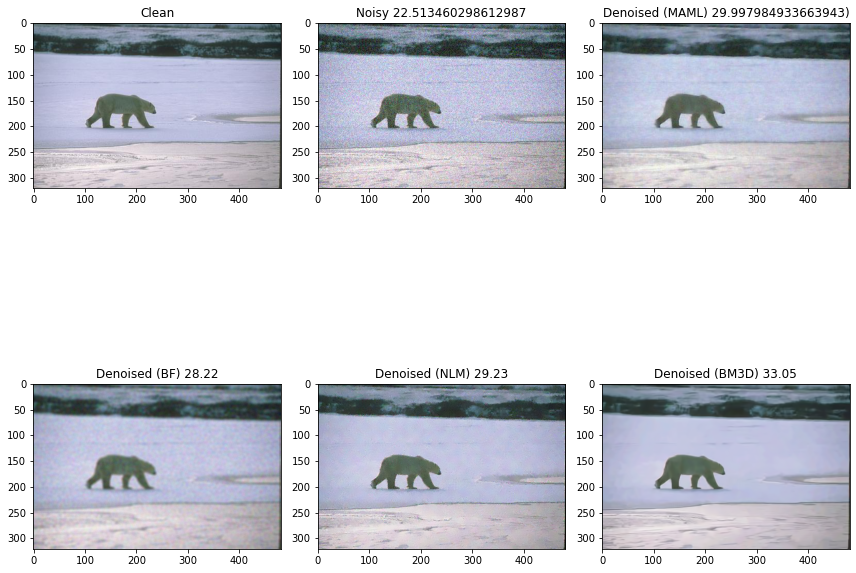

In [12]:
# nlm, bm3d, bf, denoised, noisy, src
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,12))
ax[0,0].imshow(clean_img)
ax[0,0].set_title(f"Clean")

ax[0,1].imshow(noisy_img)
ax[0,1].set_title(f"Noisy {psnr(clean_img, noisy_img)}")

ax[0,2].imshow(denoised_img)
ax[0,2].set_title(f"Denoised (MAML) {psnr(clean_img, denoised_img)})")

ax[1,0].imshow(bf_)
ax[1,0].set_title(f"Denoised (BF) {psnrBF}")

ax[1,1].imshow(nlm_)
ax[1,1].set_title(f"Denoised (NLM) {psnrNLM}")

ax[1,2].imshow(bm3d_)
ax[1,2].set_title(f"Denoised (BM3D) {psnrBM3D}")

plt.tight_layout()